In [294]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

# Table of Contents
- **[Constants](#1)**
- **[Data prep](#2)**
- **[Training and sampling functions](#3)**
- **[MLP arch improvement](#4)**
    - [Params initialisation improvement](#4-1)
    - [Kaiming init](#4-2)
    - [Batchnorm of hidden layer](#4-3)
- **[Code refactoring](#5)**
- **[Monitoring parameters across layers](#6)**

<a name='1'></a>
# Constants

In [239]:
BLOCK_SIZE = 3

HIDDEN_LAYER_SIZE = 300
EMBEDDING_SIZE = 10 
BATCH_SIZE = 256

<a name='2'></a>
# Data prep

In [217]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [218]:
chars = sorted(list(set(''.join(words))))
chars = ['.'] + chars
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

In [219]:
# build the dataset

def build_dataset(words, block_size=BLOCK_SIZE, verbose=False):
     # context length: how many charachters do we 
    X, Y = [], []
    for w in words:

        if verbose: print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            if verbose: print(''.join(itos[i] for i in context), '------>', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return {'X': X, 'Y': Y}

train_percent = 0.8
train_start_ix, train_end_ix = 0, int(train_percent * (len(words)))
eval_start_ix, eval_end_ix = train_end_ix+1, train_end_ix + int((len(words) - train_end_ix)/2)
test_start_ix, test_end_ix = eval_end_ix+1, len(words)-1
# eval_percent, test_percent = 1-train_percent/2,  1-train_percent/2; 

random.shuffle(words)
train_ds_dict = build_dataset(words=words[train_start_ix:train_end_ix], verbose=False)
train_X = train_ds_dict['X']; train_Y = train_ds_dict['Y']

eval_ds_dict = build_dataset(words=words[eval_start_ix:eval_end_ix], verbose=False)
eval_X = eval_ds_dict['X']; eval_Y = eval_ds_dict['Y']

test_ds_dict = build_dataset(words=words[test_start_ix:test_end_ix], verbose=False)
test_X = test_ds_dict['X']; test_Y = test_ds_dict['Y']

<a name='3'></a>
# Training and sampling functions

In [220]:
torch.randn((HIDDEN_LAYER_SIZE, len(chars)), requires_grad=True).dtype

torch.float32

In [221]:
(torch.randn((HIDDEN_LAYER_SIZE, len(chars)), requires_grad=True)*1).dtype

torch.float32

In [355]:
def initiate_params(input_len, hidden_layer_size=HIDDEN_LAYER_SIZE, embedding_size=EMBEDDING_SIZE):
    C = torch.randn((input_len, embedding_size))
    W1 = torch.randn((BLOCK_SIZE*embedding_size, hidden_layer_size)) * 0.01
    b1 = torch.randn(hidden_layer_size) * 0.01
    W2 = torch.randn((hidden_layer_size, input_len)) * 0.01
    b2 = torch.randn(input_len) * 0
    
    for p in [C, W1, b1, W2, b2]:
        p.requires_grad=True
        
    return {'C': C, 'W1': W1, 'W2': W2, 'b1': b1, 'b2': b2}

def forward_pass(X, parameters):
    C = parameters['C']
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    #embedding layer
    emb = C[X]

    #hidden layer
    h = torch.tanh(emb.view(-1, BLOCK_SIZE*EMBEDDING_SIZE) @ W1 + b1)

    #output layer
    logits = h @ W2 + b2
    
    return logits

def back_pass(parameters, nll_loss, lr=.1):
    # nullifying param grads
    for p in parameters.values():
        p.grad = None

    #backprop
    nll_loss.backward()

    #params update
    for k, v in parameters.items():
        if k in ['bn_mean_running', 'bn_std_running']:
            continue
        v.data -= lr * v.grad
    
    return parameters 

In [356]:
def train(train_X, train_Y, parameters, lr=0.1, 
          batch_size=BATCH_SIZE,
          epochs=15000, verbose=True):
    for _ in range(epochs):
        
        #minibatch construct
        ix = torch.randint(0, train_X.shape[0], (batch_size,))
        miniB_X = train_X[ix]
        miniB_Y = train_Y[ix]

        #train epoch
        logits = forward_pass(miniB_X, parameters)
        nll_loss = F.cross_entropy(logits, miniB_Y)
        parameters = back_pass(parameters, nll_loss, lr=lr)

        if (_ % int(epochs/5) == 0) and verbose: 
            print(nll_loss.item())
    return parameters

@torch.no_grad()
def eval_model(parameters, train_X, train_Y, eval_X, eval_Y, test_X, test_Y):
    
    # evaluating on the whole training dataset
    logits = forward_pass(train_X, parameters)
    nll_loss_train = F.cross_entropy(logits, train_Y)
    
    # evaluating on the eval dataset
    logits = forward_pass(eval_X, parameters)
    nll_loss_eval = F.cross_entropy(logits, eval_Y)
    
    # evaluating on the test dataset
    logits = forward_pass(test_X, parameters)
    nll_loss_test = F.cross_entropy(logits, test_Y)
    
    return {'train': nll_loss_train.item(), 'eval': nll_loss_eval.item(), 'test': nll_loss_test.item()}

In [351]:
def generate_name_nn(num_names, parameters):
    
    out = []
    for cnt in range(num_names):
        this_name = []
        context = [0]*BLOCK_SIZE
        for _ in range(50):
            
            #forward pass
            logits = forward_pass(torch.tensor(context), parameters)
            probs = F.softmax(logits, dim=1)
            
            #sampling
            ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
            context = context[1:] + [ix]
            this_name.append(itos[ix])
            
            if ix == 0:
                 break
        out.append(''.join(this_name)[:-1])
    return out

# generate_name_nn(15, parameters)

In [243]:
parameters = initiate_params(len(chars), hidden_layer_size=HIDDEN_LAYER_SIZE, embedding_size=EMBEDDING_SIZE)
for lr in [0.1, 0.01]:
    parameters = train(train_X, train_Y, parameters, lr=lr, 
                       batch_size=BATCH_SIZE,
                       epochs=100000, verbose=True)

3.3185389041900635
2.138143301010132
2.076359748840332
2.11557674407959
1.9730979204177856
1.9472399950027466
2.1185290813446045
2.040226459503174
2.0021636486053467
2.0475432872772217


In [244]:
eval_model(parameters, train_X, train_Y, eval_X, eval_Y, test_X, test_Y)

{'train': 2.013857126235962,
 'eval': 2.114511728286743,
 'test': 2.1123547554016113}

<a name='4'></a>
# MLP arch improvement

<a name='4-1'></a>
## Params initialisation improvement

In [247]:
parameters = initiate_params(len(chars), hidden_layer_size=HIDDEN_LAYER_SIZE, embedding_size=EMBEDDING_SIZE)

C = parameters['C']
W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']

#embedding layer
emb = C[train_X]

#hidden layer
h = torch.tanh(emb.view(-1, BLOCK_SIZE*EMBEDDING_SIZE) @ W1 + b1)


In [252]:
h.view(-1).tolist()[:10]

[0.9671034812927246,
 0.9999851584434509,
 0.9994852542877197,
 -0.6177638173103333,
 -0.9998183250427246,
 -0.9998255372047424,
 -1.0,
 -0.7930182814598083,
 -0.8678570985794067,
 0.999221920967102]

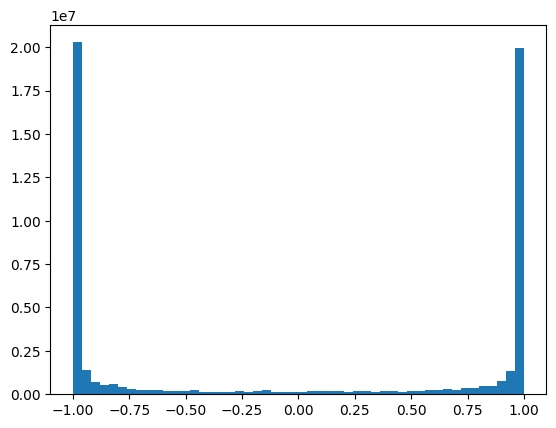

In [254]:
plt.hist(h.view(-1).tolist(), 50);

Because derivative of tanh has 1-tanh**2 element, the gradient of tanh tensor that has a lot of values 1 or -1 with have a lot of zero values. Meaning that learning will not take place. This happens because the input to tanh is widely spread, a lot of values greater or smaller that 1 or -1 respectively

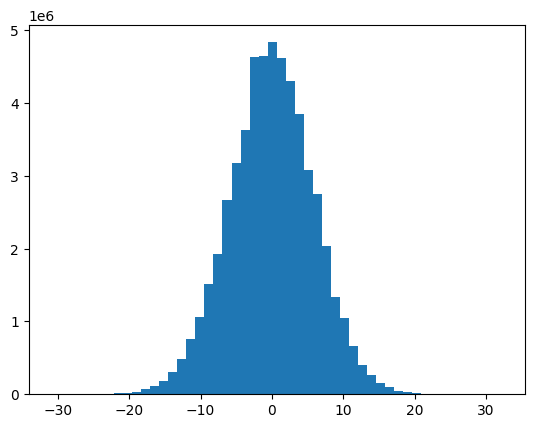

In [260]:
plt.hist((emb.view(-1, BLOCK_SIZE*EMBEDDING_SIZE) @ W1 + b1).view(-1).tolist(), 50);

In [269]:
(h.abs()>.99).shape

torch.Size([182643, 300])

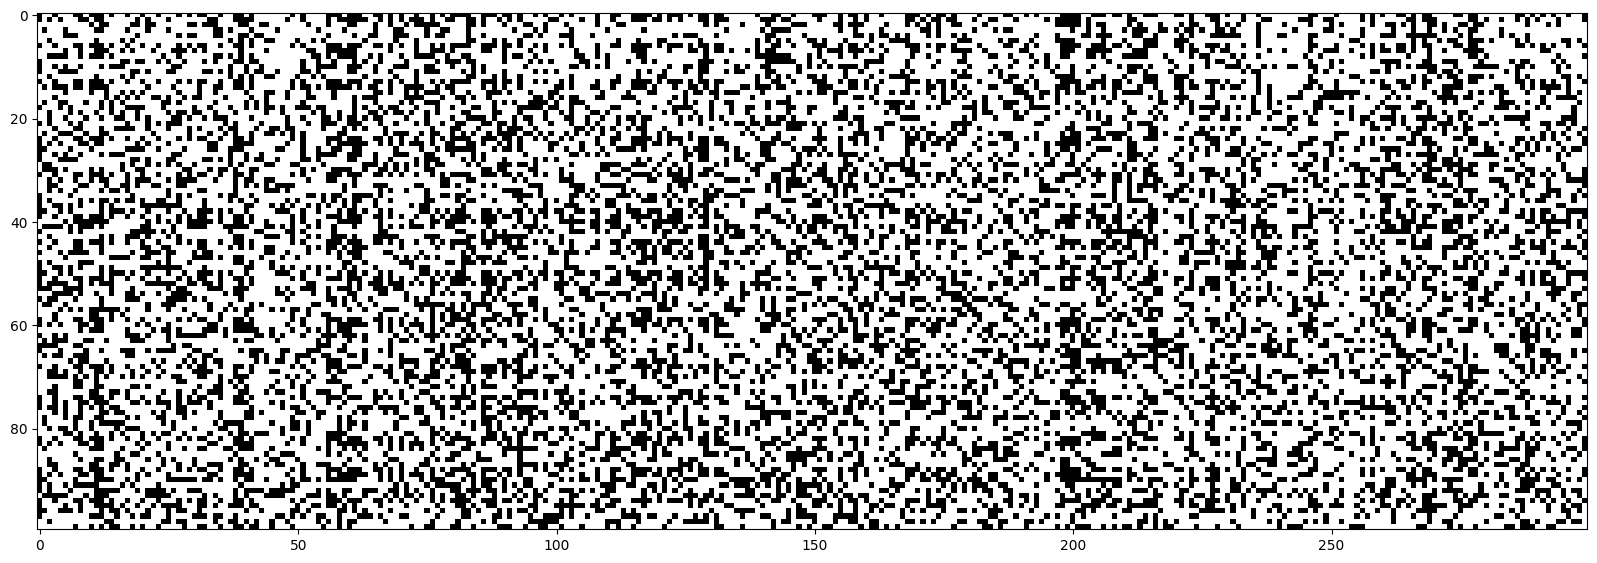

In [272]:
plt.figure(figsize=(20,10))
plt.imshow((h.abs()>.99)[:100], 
           cmap='gray', )
#            interpolation='nearest')

to correct the issue we need to reduce the spread of the tanh input by multiplyting the W1 and b1 by a small number

In [276]:
parameters = initiate_params(len(chars), hidden_layer_size=HIDDEN_LAYER_SIZE, embedding_size=EMBEDDING_SIZE)

C = parameters['C']
W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']

#embedding layer
emb = C[train_X]

#hidden layer
h = torch.tanh(emb.view(-1, BLOCK_SIZE*EMBEDDING_SIZE) @ W1 + b1)


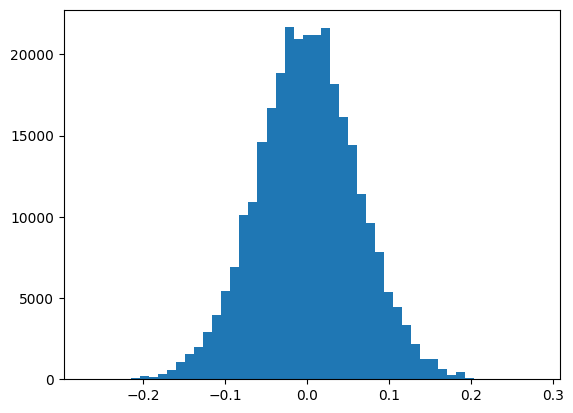

In [279]:
plt.hist(h[:1000].view(-1).tolist(), 50);

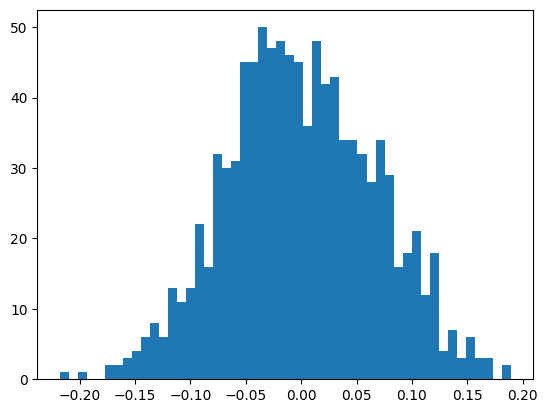

In [280]:
plt.hist((emb.view(-1, BLOCK_SIZE*EMBEDDING_SIZE) @ W1 + b1).view(-1).tolist()[:1000], 50);

In [281]:
parameters = initiate_params(len(chars), hidden_layer_size=HIDDEN_LAYER_SIZE, embedding_size=EMBEDDING_SIZE)
for lr in [0.1, 0.01]:
    parameters = train(train_X, train_Y, parameters, lr=lr, 
                       batch_size=BATCH_SIZE,
                       epochs=100000, verbose=True)

3.297126054763794
2.0667927265167236
2.039534330368042
2.1188766956329346
2.1422460079193115
2.077652931213379
2.055358648300171
1.9155855178833008
2.1107490062713623
1.998636245727539


In [282]:
eval_model(parameters, train_X, train_Y, eval_X, eval_Y, test_X, test_Y)

{'train': 1.992576003074646,
 'eval': 2.0963704586029053,
 'test': 2.0929605960845947}

<a name='4-2'></a>
## Kaiming init

It's best to preserve distributions of weights throughout the network so that they don't squash or spread too much. For this purpose the initial weights need to be adjusted by multiplying it by (gain/sqrt(fan_in)), where gain is an empirical constant set for activation type torch.nn.init.calculate_gain('tanh'), fan_in -- number of neurons. 

In [295]:
def initiate_params(input_len, hidden_layer_size=HIDDEN_LAYER_SIZE, embedding_size=EMBEDDING_SIZE):
    C = torch.randn((input_len, embedding_size))
    kaiming_mult = torch.nn.init.calculate_gain('tanh') / np.sqrt(BLOCK_SIZE*embedding_size)
    W1 = torch.randn((BLOCK_SIZE*embedding_size, hidden_layer_size)) * kaiming_mult
    b1 = torch.randn(hidden_layer_size) * 0.01
    W2 = torch.randn((hidden_layer_size, input_len)) * 0.01
    b2 = torch.randn(input_len) * 0
    
    for p in [C, W1, b1, W2, b2]:
        p.requires_grad=True
        
    return {'C': C, 'W1': W1, 'W2': W2, 'b1': b1, 'b2': b2}

In [296]:
parameters = initiate_params(len(chars), hidden_layer_size=HIDDEN_LAYER_SIZE, embedding_size=EMBEDDING_SIZE)
for lr in [0.1, 0.01]:
    parameters = train(train_X, train_Y, parameters, lr=lr, 
                       batch_size=BATCH_SIZE,
                       epochs=100000, verbose=True)

3.295884132385254
2.1025094985961914
2.0857131481170654
2.004974842071533
2.1097326278686523
1.9526746273040771
2.0257694721221924
2.089358329772949
2.0143051147460938
1.9019824266433716


In [297]:
eval_model(parameters, train_X, train_Y, eval_X, eval_Y, test_X, test_Y)

{'train': 1.9809476137161255,
 'eval': 2.0963335037231445,
 'test': 2.0929064750671387}

<a name='4-3'></a>
## Batchnorm of hidden layer
Amending several training functions to include normalisation of data within batches

In [361]:
def initiate_params(input_len, hidden_layer_size=HIDDEN_LAYER_SIZE, embedding_size=EMBEDDING_SIZE):
    C = torch.randn((input_len, embedding_size))
    
    kaiming_mult = torch.nn.init.calculate_gain('tanh') / np.sqrt(BLOCK_SIZE*embedding_size)
    W1 = torch.randn((BLOCK_SIZE*embedding_size, hidden_layer_size)) * kaiming_mult
#     b1 = torch.randn(hidden_layer_size) * 0.01
    W2 = torch.randn((hidden_layer_size, input_len)) * 0.01
    b2 = torch.randn(input_len) * 0
    
    bn_gain = torch.ones((1, hidden_layer_size))
    bn_bias = torch.zeros((1, hidden_layer_size))
    
    bn_mean_running = torch.zeros((1, hidden_layer_size))
    bn_std_running = torch.ones((1, hidden_layer_size))
    
    for p in [C, W1, b1, W2, b2, bn_gain, bn_bias]:
        p.requires_grad=True
        
    return {'C': C, 'W1': W1, 'W2': W2, 'b2': b2, 
            'bn_gain': bn_gain, 'bn_bias': bn_bias, 
            'bn_mean_running': bn_mean_running, 
            'bn_std_running': bn_std_running} #'b1': b1

In [377]:
def forward_pass(X, parameters, training=True):
    C = parameters['C']
    W1 = parameters['W1']
#     b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    bn_gain = parameters['bn_gain']
    bn_bias = parameters['bn_bias']
    bn_mean_running = parameters['bn_mean_running']
    bn_std_running = parameters['bn_std_running']
    
    #embedding layer
    emb = C[X]

    #hidden layer
    ## linear sublayer
    dense = emb.view(-1, BLOCK_SIZE*EMBEDDING_SIZE) @ W1# + b1
    ## batch normalisation sublayer
    dense_std = dense.std(0, keepdims=True)
    dense_mean = dense.mean(0, keepdims=True)
    if training:
        dense_norm = (dense - dense_mean) / dense_std
    else:
        dense_norm = (dense - bn_mean_running) / bn_std_running
    dense_norm = bn_gain * dense_norm + bn_bias    
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * dense_mean
        bn_std_running = 0.999 * bn_std_running + 0.001 * dense_std
        parameters['bn_mean_running'] = bn_mean_running
        parameters['bn_std_running'] = bn_std_running
    ## activation sublayer
    h = torch.tanh(dense_norm)

    #output layer
    logits = h @ W2 + b2
    
    return logits

@torch.no_grad()
def eval_model(parameters, train_X, train_Y, eval_X, eval_Y, test_X, test_Y):
    
    # evaluating on the whole training dataset
    logits = forward_pass(train_X, parameters, training=False)
    nll_loss_train = F.cross_entropy(logits, train_Y)
    
    # evaluating on the eval dataset
    logits = forward_pass(eval_X, parameters, training=False)
    nll_loss_eval = F.cross_entropy(logits, eval_Y)
    
    # evaluating on the test dataset
    logits = forward_pass(test_X, parameters, training=False)
    nll_loss_test = F.cross_entropy(logits, test_Y)
    
    return {'train': nll_loss_train.item(), 'eval': nll_loss_eval.item(), 'test': nll_loss_test.item()}

In [380]:
parameters = initiate_params(len(chars), hidden_layer_size=HIDDEN_LAYER_SIZE, embedding_size=EMBEDDING_SIZE)
for lr in [0.1, 0.01]:
    parameters = train(train_X, train_Y, parameters, lr=lr, 
                       batch_size=BATCH_SIZE,
                       epochs=100000, verbose=True)

3.301583766937256
2.1566786766052246
1.9872115850448608
2.221686363220215
1.9340271949768066
2.0801711082458496
2.0146124362945557
1.9799646139144897
2.0666842460632324
2.167241334915161


In [381]:
eval_model(parameters, train_X, train_Y, eval_X, eval_Y, test_X, test_Y)

{'train': 1.9913216829299927,
 'eval': 2.089219808578491,
 'test': 2.0834715366363525}

<a name='5'></a>
# Code refactoring

In [776]:
HIDDEN_LAYER_SIZE = 100
EMBEDDING_SIZE = 10 
BATCH_SIZE = 32
BLOCK_SIZE = 3

In [777]:
train_percent = 0.8
train_start_ix, train_end_ix = 0, int(train_percent * (len(words)))
eval_start_ix, eval_end_ix = train_end_ix+1, train_end_ix + int((len(words) - train_end_ix)/2)
test_start_ix, test_end_ix = eval_end_ix+1, len(words)-1
# eval_percent, test_percent = 1-train_percent/2,  1-train_percent/2; 

random.shuffle(words)
train_ds_dict = build_dataset(words=words[train_start_ix:train_end_ix], verbose=False)
train_X = train_ds_dict['X']; train_Y = train_ds_dict['Y']

eval_ds_dict = build_dataset(words=words[eval_start_ix:eval_end_ix], verbose=False)
eval_X = eval_ds_dict['X']; eval_Y = eval_ds_dict['Y']

test_ds_dict = build_dataset(words=words[test_start_ix:test_end_ix], verbose=False)
test_X = test_ds_dict['X']; test_Y = test_ds_dict['Y']

In [778]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
    
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [810]:
def forward_pass(X, layers):
    emb = C[X] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    return x

def back_pass(parameters, nll_loss, lr=.1):
    # nullifying param grads
#     for p in parameters:
#         p.grad = None
    
#     loss.backward()

#     #params update
#     for k, v in parameters.items():
#         if k in ['bn_mean_running', 'bn_std_running']:
#             continue
#         v.data -= lr * v.grad
    for layer in layers:
        layer.out.retain_grad()
    
    for p in parameters:
        p.grad = None
    nll_loss.backward()
  
    # update
#     lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    return parameters 

@torch.no_grad()
def eval_model(parameters, layers, train_X, train_Y, eval_X, eval_Y, test_X, test_Y):
    
    # evaluating on the whole training dataset
    logits = forward_pass(train_X, layers)
    nll_loss_train = F.cross_entropy(logits, train_Y)
    
    # evaluating on the eval dataset
    logits = forward_pass(eval_X, layers)
    nll_loss_eval = F.cross_entropy(logits, eval_Y)
    
    # evaluating on the test dataset
    logits = forward_pass(test_X, layers)
    nll_loss_test = F.cross_entropy(logits, test_Y)
    
    return {'train': nll_loss_train.item(), 'eval': nll_loss_eval.item(), 'test': nll_loss_test.item()}

In [811]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((len(chars), EMBEDDING_SIZE), generator=g)
# layers = [
#   Linear(EMBEDDING_SIZE * BLOCK_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
#   Linear(          HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
#   Linear(          HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
#   Linear(          HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
#   Linear(          HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, bias=False), BatchNorm1d(HIDDEN_LAYER_SIZE), Tanh(),
#   Linear(          HIDDEN_LAYER_SIZE,        len(chars), bias=False), BatchNorm1d(len(chars))
# ]

layers = [
  Linear( EMBEDDING_SIZE * BLOCK_SIZE, HIDDEN_LAYER_SIZE), Tanh(),
  Linear(           HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE), Tanh(),
  Linear(           HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE), Tanh(),
  Linear(           HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE), Tanh(),
  Linear(           HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE), Tanh(),
  Linear(           HIDDEN_LAYER_SIZE, len(chars)),
]

with torch.no_grad():
    # last layer: make less confident
#     layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [824]:
# same optimization as last time
max_steps = 200000
batch_size = BATCH_SIZE
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y

    # forward pass
    logits = forward_pass(Xb, layers)
    nll_loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    lr = .1 if i<=1e5 else 0.01
    parameters = back_pass(parameters, nll_loss, lr=.1)
    
#     # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {nll_loss.item():.4f}')
    lossi.append(nll_loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 5000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.3948
   1000/ 200000: 2.0763
   2000/ 200000: 2.4025


KeyboardInterrupt: 

eval_model(parameters, layers, train_X, train_Y, eval_X, eval_Y, test_X, test_Y)

<a name='6'></a>
# Monitoring parameters across layers

layer 1 (      Tanh): mean -0.06, std 0.78, saturated: 26.16%
layer 3 (      Tanh): mean +0.01, std 0.76, saturated: 19.41%
layer 5 (      Tanh): mean -0.01, std 0.77, saturated: 21.16%
layer 7 (      Tanh): mean -0.02, std 0.79, saturated: 20.31%
layer 9 (      Tanh): mean -0.02, std 0.74, saturated: 15.50%


Text(0.5, 1.0, 'activation distribution')

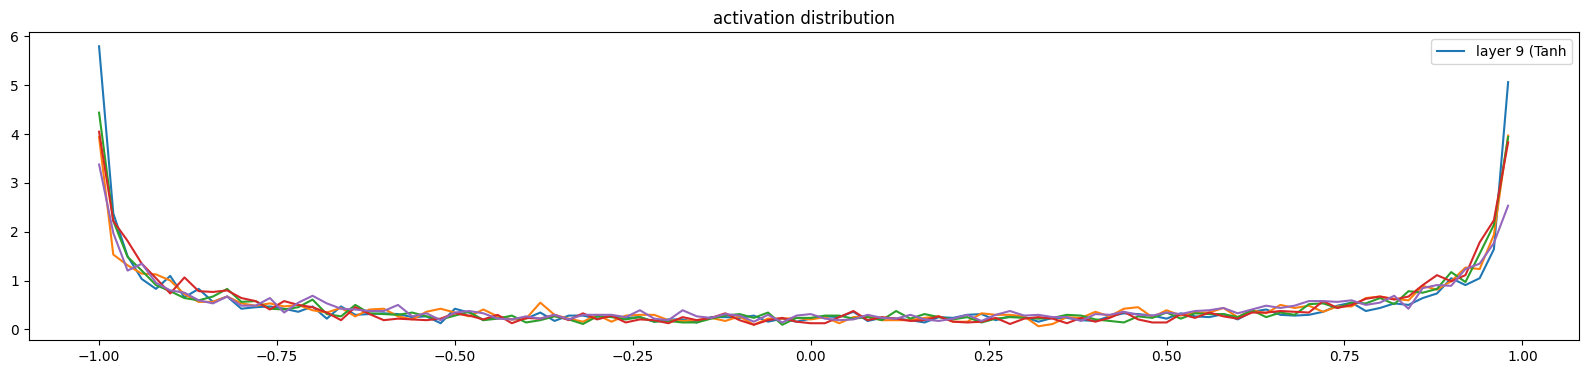

In [818]:
'''
this graph shows the layers ouputs, essentially the result of a forward pass. 
The distribution should be uniform without too much saturation. Batchnorm takes care of it.
'''

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % 
              (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 1 (      Tanh): mean +0.000042, std 3.301700e-03
layer 3 (      Tanh): mean +0.000001, std 2.974253e-03
layer 5 (      Tanh): mean +0.000051, std 2.987546e-03
layer 7 (      Tanh): mean -0.000036, std 3.166843e-03
layer 9 (      Tanh): mean -0.000004, std 3.065458e-03


Text(0.5, 1.0, 'gradient distribution')

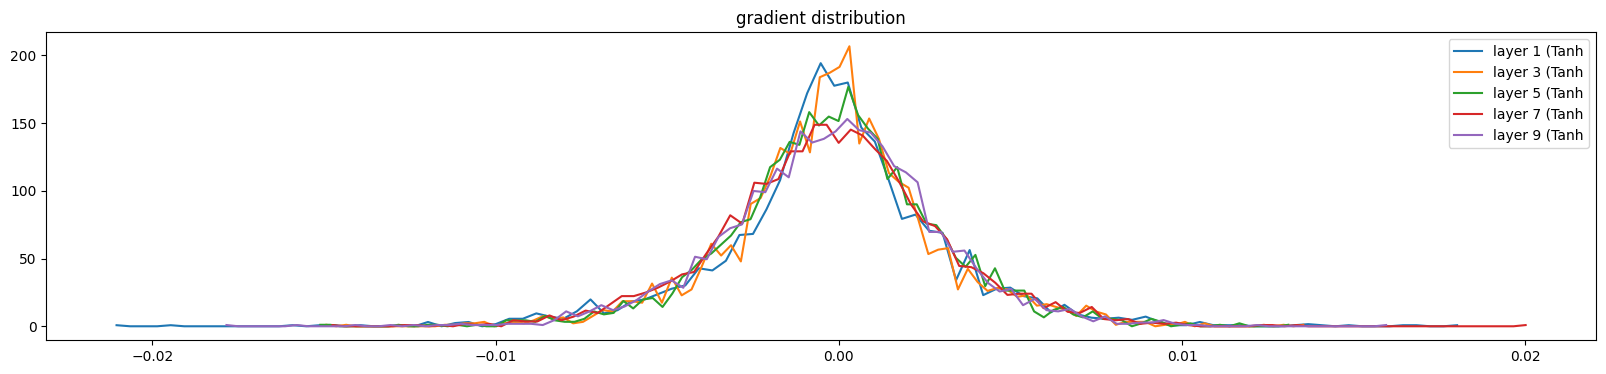

In [819]:
'''
this graph shows the gradients of each layer output, essentially the result of a backward pass 
on the scale of layers. The distribution shrinks b/c tanh is a shrinking function. Batchnorm takes care of it.
'''

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000181 | std 1.250213e-02 | grad:data ratio 1.230685e-02
weight  (30, 100) | mean -0.000163 | std 9.731629e-03 | grad:data ratio 3.012287e-02
weight (100, 100) | mean -0.000020 | std 7.157633e-03 | grad:data ratio 4.028931e-02
weight (100, 100) | mean +0.000107 | std 6.489210e-03 | grad:data ratio 3.654616e-02
weight (100, 100) | mean -0.000041 | std 6.604245e-03 | grad:data ratio 3.752831e-02
weight (100, 100) | mean +0.000083 | std 7.044407e-03 | grad:data ratio 4.107777e-02
weight  (100, 27) | mean +0.000000 | std 2.097906e-02 | grad:data ratio 2.054496e-01


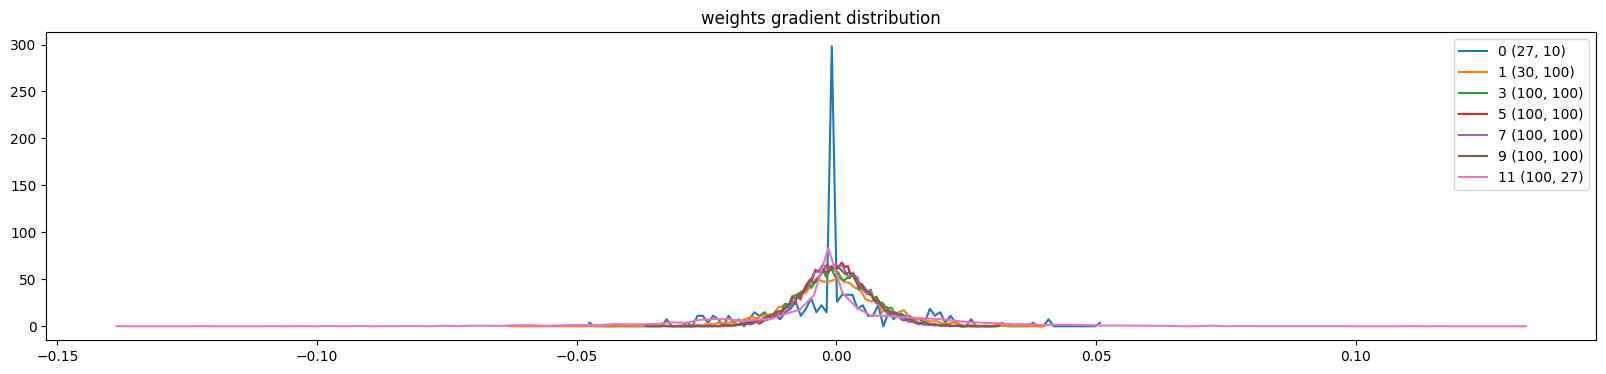

In [820]:
'''
this graph shows how much we are correcting our parameters by. So similar to previous graph but on the level of 
parameters instead of layers output. 
Separately we calculate the ratio of that number to the parameters themselves, we should 
not jump too fast. All the numbers should be similar across layers. 

Longer training and batchnorm takes care of it.
'''

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % 
              (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

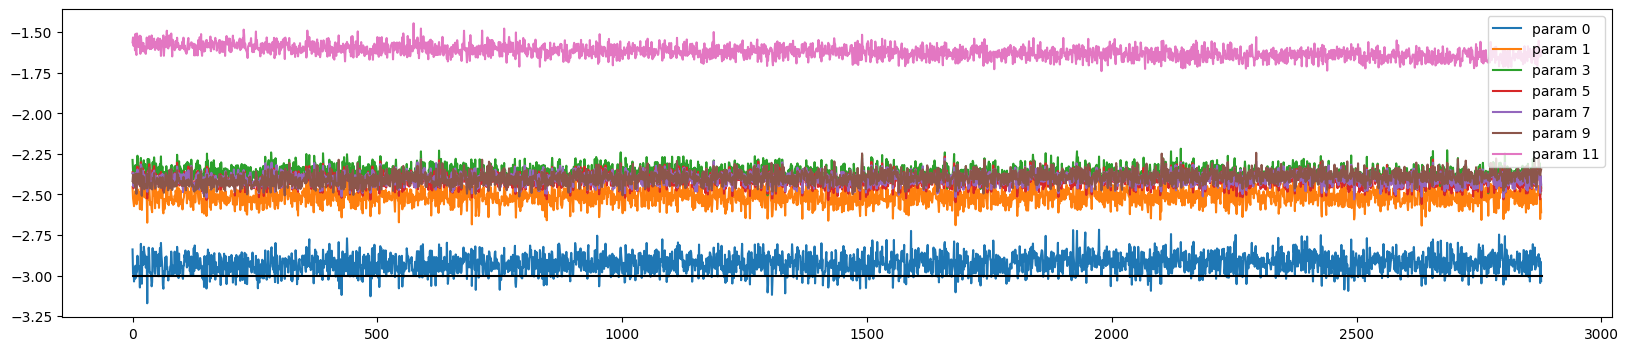

In [821]:
'''
this graph shows by how much we change the data at every iteration, 
i.e. ratio of lr*gradient to the parameters data. 
It should not be much different from ~1e-3.
Last layer here learns faster because at initiation we devided its data by 10.
We need to adjust learning rate so that updates come at a reasonable rate.
'''

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);